In [293]:
import pandas as pd
import numpy as np
import random

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import keras
from keras.preprocessing import text, sequence
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam, rmsprop
from keras import regularizers
from keras.layers.normalization import BatchNormalization

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC

from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from get_labeled_dfs import *
from process_text import *

In [294]:
# getting data
corpus_df, val_corpus_df, emotion_df, val_emotion_df, valence_df, val_valence_df = get_labeled_dfs()


In [295]:
# using custom class method to process data
processor = Process_Text_Data()
processor.transform(corpus_df, RNN=True)


In [296]:
corpus_df.head()


,text
0,test to predict breast cancer relapse is approved
1,two hussein allies are hanged iraqi official says
2,sights and sounds from ces
3,schuey sees ferrari unveil new car
4,closings and cancellations top advice on flu o...


In [297]:
emotion_df.head()

,anger,disgust,fear,joy,sadness,surprise,max,label
0,0,0,15,38,9,11,joy,3
1,24,26,16,13,38,5,sadness,4
2,0,0,0,17,0,4,joy,3
3,0,0,0,46,0,31,joy,3
4,1,0,23,8,11,8,fear,2


In [298]:
length = []
for i in corpus_df['text']:
    length.append(len(i.split()))
max(length)

15

## RNN: Emotion Labels

In [313]:
# create a set of unique words in the corpus
vocab = set()
for headline in corpus_df['text']:
    for word in headline.split():
        vocab.add(word)

# get vectors from the pretrained vocab and create a dictionary with the words from the set as keys
glove_embeddings = {}
with open('/Users/flatironschool/Desktop/glove/glove.6B.300d.txt', 'rb') as f:
    for i in f:
        key_vec = i.split()
        word = key_vec[0].decode('utf-8')
        if word in vocab:
            glove_embeddings[word] = np.array(key_vec[1:], dtype=np.float32)

In [314]:
X = corpus_df['text']
y = emotion_df['label']

tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X))

# assign a unique number to each word in the corpus and represents texts via these numbers
sequences = tokenizer.texts_to_sequences(X)
# add zeros to the front of each sequence as necessary to make them all the same length
padded_X = sequence.pad_sequences(sequences, maxlen=10)


In [315]:
len(tokenizer.word_index) + 1

2940

In [316]:
# create an array of zeros the size of the vocabulary by the size of the word vectors
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))

# fill the array so that the word vectors that fill the array correspond to their sequence numbers
for ind, word in enumerate(tokenizer.word_index.keys()):
    if word in glove_embeddings.keys():
        embedding_matrix[ind + 1, :] = glove_embeddings[word]


In [320]:
# random.seed(2)
# train_list = np.random.choice(range(0,1000), size=750, replace=False)
# test_list = [i for i in range(0,1000) if i not in train_list]

# X_train = padded_X[train_list]
# X_test = padded_X[test_list]

X_train, X_test, y_train, y_test = train_test_split(padded_X, y, test_size=0.2, stratify=y, random_state=42)

# labels one hot encoded
y_train_onehot = pd.get_dummies(y_train).values
y_test_onehot = pd.get_dummies(y_test).values

# USE SMOTENC to balance classes on the training set
smt = SMOTENC(sampling_strategy='not majority', random_state=42, categorical_features=[0,2,3,4,5,6,7,8,9])
X_res, y_res = smt.fit_resample(X_train, y_train_onehot)




In [322]:
model = Sequential()

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=10, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=rmsprop(lr=.002, decay=.00001),
              metrics=['accuracy'])


history = model.fit(X_res, 
                    y_res,
                    epochs=20,
                    batch_size=100,
                    class_weight='balanced',
                    validation_data=(X_test, y_test_onehot))

Train on 1740 samples, validate on 200 samples
Epoch 1/20
1740/1740 [==============================] - 13s 8ms/step - loss: 0.0783 - acc: 0.6310 - val_loss: 0.1203 - val_acc: 0.4200
Epoch 2/20
1740/1740 [==============================] - 1s 350us/step - loss: 0.0359 - acc: 0.8655 - val_loss: 0.1148 - val_acc: 0.4600
Epoch 3/20
1740/1740 [==============================] - 1s 350us/step - loss: 0.0222 - acc: 0.9195 - val_loss: 0.1099 - val_acc: 0.5250
Epoch 4/20
1740/1740 [==============================] - 1s 345us/step - loss: 0.0149 - acc: 0.9500 - val_loss: 0.1155 - val_acc: 0.4850
Epoch 5/20
1740/1740 [==============================] - 1s 362us/step - loss: 0.0103 - acc: 0.9655 - val_loss: 0.1211 - val_acc: 0.4750
Epoch 6/20
1740/1740 [==============================] - 1s 369us/step - loss: 0.0065 - acc: 0.9799 - val_loss: 0.1130 - val_acc: 0.5250
Epoch 7/20
1740/1740 [==============================] - 1s 364us/step - loss: 0.0054 - acc: 0.9862 - val_loss: 0.1060 - val_acc: 0.5600
Ep

In [323]:
model.evaluate(X_test, y_test_onehot)

200/200 [==============================] - 0s 344us/step


[0.12724614262580872, 0.535]

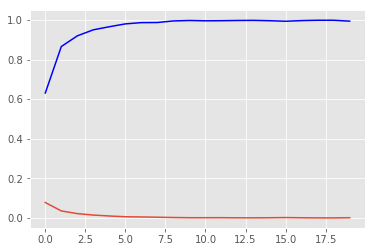

In [324]:
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')

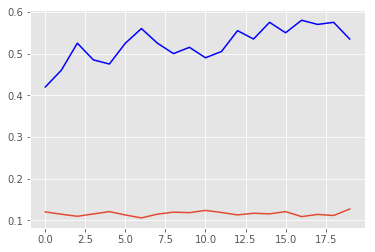

In [325]:
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')

In [326]:
# model.save('RNN_emotion.h5')

In [327]:
preds = model.predict_on_batch(X_test)

emotion_preds = pd.DataFrame({"Prediction Anger":preds[:,0], "Prediction Disgust":preds[:,1], "Prediction Fear":preds[:,2], "Prediction Joy":preds[:,3], "Prediction Sadness":preds[:,4], "Prediction Surprise":preds[:,5], "Anger":y_test[:,0], "Disgust":y_test[:,1], "Fear": y_test[:,2], "Joy": y_test[:,3], "Sadness": y_test[:,4], "Surprise": y_test[:,5]})
emotion_preds.head()

ValueError: Can only tuple-index with a MultiIndex

# RNN with Valence Labels

In [258]:
X = corpus_df['text']
y = valence_df['label']

tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(list(X))
sequences = tokenizer.texts_to_sequences(X)
padded_X = sequence.pad_sequences(sequences, maxlen=10)


In [272]:
random.seed(3)
train_list = np.random.choice(range(0,1000), size=750, replace=False)
test_list = [i for i in range(0,1000) if i not in train_list]

X_train = padded_X[train_list]
X_test = padded_X[test_list]

# labels one hot encoded
y_train = (y.iloc[train_list]).values
y_test = (y.iloc[test_list]).values

y_train_binary = keras.utils.to_categorical(y_train, 3)
y_test_binary = keras.utils.to_categorical(y_test, 3)

# USE SMOTENC to balance classes on the training set

# smt = SMOTENC(sampling_strategy='not majority', random_state=42, categorical_features=[0,1,2])
# X_res, y_res = smt.fit_resample(X_train, y_train_binary)

model = Sequential()

model.add(Embedding(num_words, 300, weights=[embedding_matrix], input_length=10, trainable=False))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(LSTM(32, activation='relu'))
model.add(BatchNormalization())
# model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=rmsprop(lr=.003, decay=.00001),
              metrics=['accuracy'])

history = model.fit(X_train, 
                    y_train_binary,
                    epochs=20,
                    batch_size=100,
                    class_weight='balanced',
                    validation_data=(X_test, y_test_binary))


Train on 750 samples, validate on 250 samples
Epoch 1/20
750/750 [==============================] - 12s 16ms/step - loss: 0.2353 - acc: 0.4600 - val_loss: 0.1739 - val_acc: 0.6640
Epoch 2/20
750/750 [==============================] - 0s 387us/step - loss: 0.1136 - acc: 0.7773 - val_loss: 0.1507 - val_acc: 0.7040
Epoch 3/20
750/750 [==============================] - 0s 397us/step - loss: 0.0621 - acc: 0.9027 - val_loss: 0.1571 - val_acc: 0.7000
Epoch 4/20
750/750 [==============================] - 0s 391us/step - loss: 0.0350 - acc: 0.9547 - val_loss: 0.1701 - val_acc: 0.6400
Epoch 5/20
750/750 [==============================] - 0s 391us/step - loss: 0.0200 - acc: 0.9787 - val_loss: 0.1536 - val_acc: 0.6880
Epoch 6/20
750/750 [==============================] - 0s 385us/step - loss: 0.0113 - acc: 0.9893 - val_loss: 0.1720 - val_acc: 0.6360
Epoch 7/20
750/750 [==============================] - 0s 405us/step - loss: 0.0082 - acc: 0.9920 - val_loss: 0.1631 - val_acc: 0.6680
Epoch 8/20
750/7

In [273]:
model.evaluate(X_test, y_test_binary)


250/250 [==============================] - 0s 253us/step


[0.17138865721225738, 0.7040000014305114]

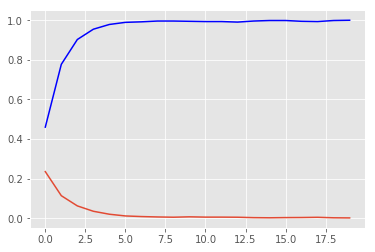

In [274]:
plt.plot(model.history.history['acc'], color='blue', label='acc')
plt.plot(model.history.history['loss'], label='loss')


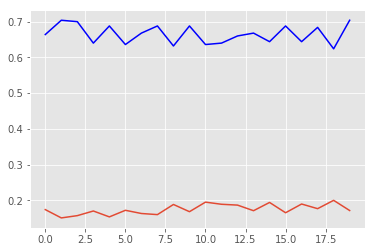

In [275]:
plt.plot(model.history.history['val_acc'], color='blue', label='val_acc')
plt.plot(model.history.history['val_loss'], label='val_loss')


In [276]:
preds = model.predict_on_batch(X_test)

In [291]:
valence_preds = pd.DataFrame({"Prediction Neg":preds[:,0], "Prediction Pos":preds[:,1], "Prediction Neu":preds[:,2], "Neg":y_test_binary[:,0], "Pos":y_test_binary[:,1], "Neu": y_test_binary[:,2], "Actual Intensity": valence_df['valence'][test_list]})
valence_preds['Prediction Label'] = valence_preds[['Prediction Neg', "Prediction Pos", 'Prediction Neu']].idxmax(axis=1)

def label_preds(row):
    if row == 'Prediction Neg':
        return 0
    if row == 'Prediction Pos':
        return 1
    if row == 'Prediction Neu':
        return 2
valence_preds['Prediction Label'] = valence_preds['Prediction Label'].apply(label_preds)
valence_preds.head()

,Prediction Neg,Prediction Pos,Prediction Neu,Neg,Pos,Neu,Actual Intensity,Prediction Label
0,0.000795,0.998327,0.000878,0.0,1.0,0.0,32,1
3,0.000034,0.990617,0.009349,0.0,1.0,0.0,40,1
5,0.989483,0.000674,0.009843,1.0,0.0,0.0,-67,0
7,0.896963,0.100604,0.002433,0.0,0.0,1.0,-9,0
10,0.078879,0.884988,0.036133,1.0,0.0,0.0,-34,1


{'whiskers': [<matplotlib.lines.Line2D at 0x1a85655cf8>,
 'caps': [<matplotlib.lines.Line2D at 0x1a856603c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a856556a0>],
 'medians': [<matplotlib.lines.Line2D at 0x1a85660a58>],
 'fliers': [<matplotlib.lines.Line2D at 0x1a85660da0>],
 'means': []}

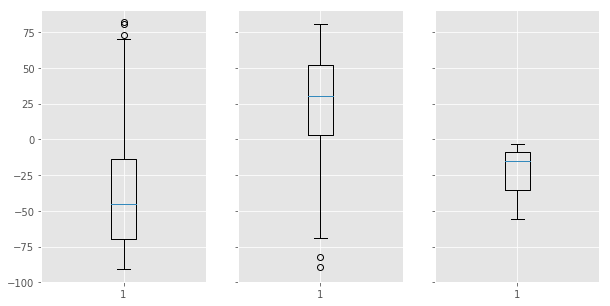

In [278]:
neg_pred = valence_preds.loc[(valence_preds['Prediction Label']=='Prediction Neg')]
pos_pred = valence_preds.loc[(valence_preds['Prediction Label']=='Prediction Pos')]
neu_pred = valence_preds.loc[(valence_preds['Prediction Label']=='Prediction Neu')]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(10, 5))
# fig.add_subplot(1)
ax1.boxplot(neg_pred['Actual Intensity'])
# fig.add_subplot(2)
ax2.boxplot(pos_pred['Actual Intensity'])
# fig.add_subplot(3)
ax3.boxplot(neu_pred['Actual Intensity'])

In [279]:
# model.save('RNN_valence.h5')
# 70.4% accuracy

In [292]:
confusion_matrix(y.iloc[test_list], valence_preds['Prediction Label'])

array([[92, 19,  2],
       [22, 83,  0],
       [11, 20,  1]])